In [1]:
from utils import plot_history, plot_result, calc_mean_image_metrics, predict_all
from losses import ssim_l2

In [2]:
import numpy as np

import os

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Add, Subtract
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import callbacks
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
images_clear_tt = np.load('images_clear_tt.npy')
images_noised_tt = np.load('images_noised_tt.npy')
images_clear_tt = images_clear_tt[:4000]
images_noised_tt = images_noised_tt[:4000]

In [4]:
#images_noised_train, images_noised_test, images_clear_train, images_clear_test = train_test_split(images_noised_tt,
#                                                                                                 images_clear_tt,
#                                                                                                 test_size=0.2,
#                                                                                                 random_state=42)

In [4]:
def dncnn_res(img_shape):

    input = Input(img_shape)
    n_blocks = 16
    x = Conv2D(128, kernel_size=(3,3),  bias_initializer='glorot_normal',
                                        kernel_initializer='glorot_normal',
                                        padding='same')(input)
    x = Activation('gelu')(x)
    for i in range(n_blocks):
        xx = Conv2D(128, kernel_size=(3,3),  bias_initializer='glorot_normal', 
                                             kernel_initializer='glorot_normal',
                                             padding='same')(x)
        xx = BatchNormalization()(xx)
        xx = Activation('gelu')(xx)
        xx = Add()([x, xx])
        x = xx
    x = Conv2D(3, kernel_size=(3,3),  bias_initializer='glorot_normal', 
                                      kernel_initializer='glorot_normal',
                                      padding='same')(x)
    out = Subtract()([input, x])

    model = Model(input, out)
    model.summary()
    
    return model

In [5]:
model = dncnn_res((256,256,3))
reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss',
                                        factor=0.1,
                                        patience=5)

model.compile(optimizer=Adamax(learning_rate=1e-2), loss=ssim_l2)

history = model.fit(images_noised_tt, images_clear_tt,
                    epochs=30,
                    callbacks=[reduce_lr],
                    validation_split=0.2,
                    #validation_data=(images_noised_test, images_clear_test),
                    batch_size=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 12  3584        ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 activation (Activation)        (None, 256, 256, 12  0           ['conv2d[0][0]']                 
                                8)                                                            

                                                                                                  
 conv2d_7 (Conv2D)              (None, 256, 256, 12  147584      ['add_5[0][0]']                  
                                8)                                                                
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 256, 256, 12  512        ['conv2d_7[0][0]']               
 rmalization)                   8)                                                                
                                                                                                  
 activation_7 (Activation)      (None, 256, 256, 12  0           ['batch_normalization_6[0][0]']  
                                8)                                                                
                                                                                                  
 add_6 (Ad

                                8)                                'activation_13[0][0]']          
                                                                                                  
 conv2d_14 (Conv2D)             (None, 256, 256, 12  147584      ['add_12[0][0]']                 
                                8)                                                                
                                                                                                  
 batch_normalization_13 (BatchN  (None, 256, 256, 12  512        ['conv2d_14[0][0]']              
 ormalization)                  8)                                                                
                                                                                                  
 activation_14 (Activation)     (None, 256, 256, 12  0           ['batch_normalization_13[0][0]'] 
                                8)                                                                
          

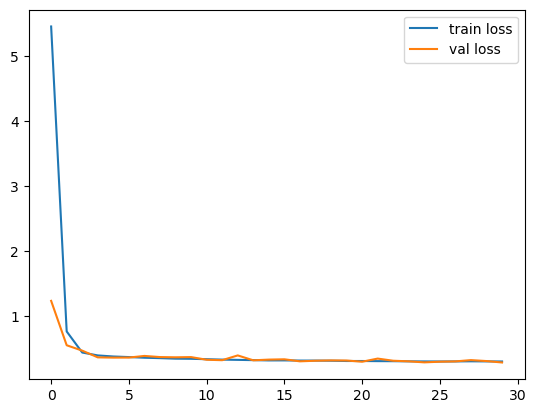

In [6]:
plot_history(history)

In [8]:
images_clear_val = np.load('images_clear_val.npy')
images_noised_val = np.load('images_noised_val.npy')
y = predict_all(model, images_noised_val)

1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 47ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mean PSNR=23.457826614379883
mean SSIM=0.6295141577720642


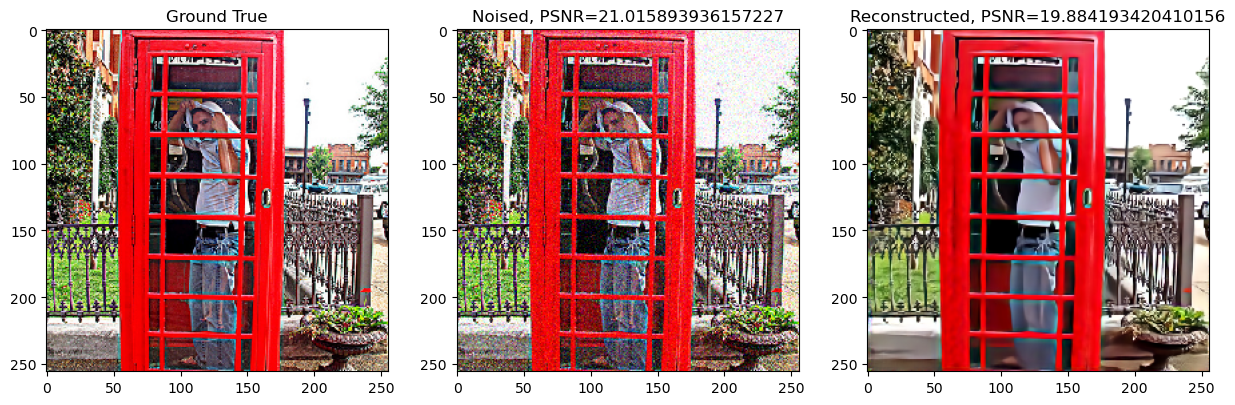

In [9]:
n=334
max_value=1
psnr, ssim = calc_mean_image_metrics(images_clear_val, y, max_value=max_value)
print (f'mean PSNR={psnr}')
print (f'mean SSIM={ssim}')
plot_result(images_clear_val[n],
            images_noised_val[n],
            y[n],
            max_value=max_value
           )

In [10]:
y_tt = predict_all(model, images_noised_tt)

1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 58ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mean PSNR=24.744274139404297
mean SSIM=0.7219855785369873


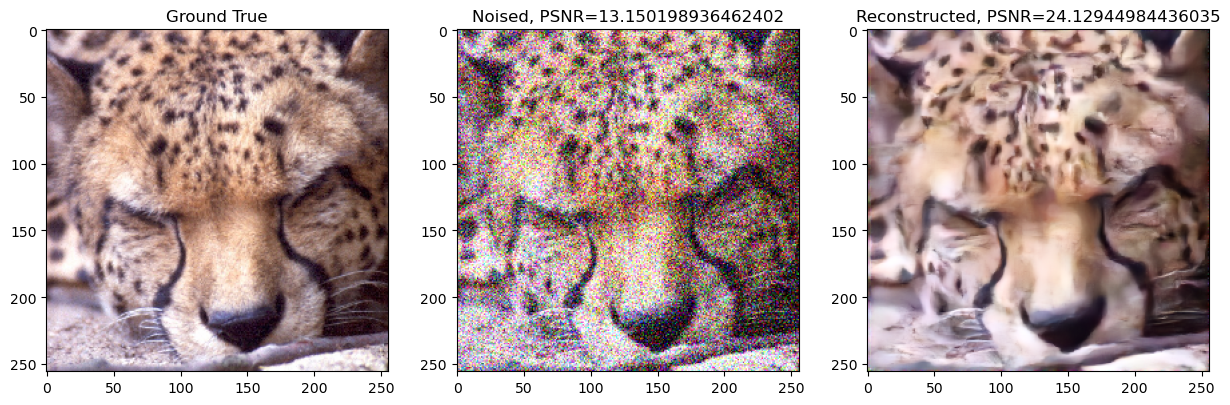

In [12]:
n=5
max_value=1
psnr, ssim = calc_mean_image_metrics(images_clear_tt, y_tt, max_value=max_value)
print (f'mean PSNR={psnr}')
print (f'mean SSIM={ssim}')
plot_result(images_clear_tt[n],
            images_noised_tt[n],
            y_tt[n],
            max_value=max_value
           )